In [1]:
import zipfile
import os

# Unzip the dataset first
dataset_zip_path = '/content/Potato.zip'  # Replace with your zip file path
extract_to = ''

with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import os
import random
from PIL import Image

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define paths
base_dir = 'Potato'  # Update this with your actual path
train_dir = os.path.join(base_dir, 'Train')
val_dir = os.path.join(base_dir, 'Val')
test_dir = os.path.join(base_dir, 'Test')

# Classes
classes = ['Early Blight', 'Healthy', 'Late Blight']
num_classes = len(classes)

# Image parameters
img_width, img_height = 256, 256
batch_size = 32

# Data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 5702 images belonging to 3 classes.
Found 1282 images belonging to 3 classes.
Found 144 images belonging to 3 classes.


In [2]:
def create_cnn_model(optimizer):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
        MaxPooling2D(2, 2),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [3]:
# Define optimizers
optimizers = {
    'Adam': Adam(learning_rate=0.001),
    'SGD': SGD(learning_rate=0.001),
    'RMSprop': RMSprop(learning_rate=0.001)
}

# Dictionary to store results
results = {}
history_dict = {}

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train models
for opt_name, optimizer in optimizers.items():
    print(f"\nTraining with {opt_name} optimizer...")
    model = create_cnn_model(optimizer)

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=10,
        validation_data=val_generator,
        validation_steps=val_generator.samples // batch_size,
        callbacks=[early_stopping],
        verbose=1)

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_generator, verbose=0)
    print(f"{opt_name} Test Accuracy: {test_acc:.4f}")

    # Store results
    results[opt_name] = {
        'model': model,
        'test_acc': test_acc,
        'test_loss': test_loss,
        'history': history
    }
    history_dict[opt_name] = history.history


Training with Adam optimizer...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 115s 598ms/step - accuracy: 0.6716 - loss: 0.8500 - val_accuracy: 0.8297 - val_loss: 0.4152
Epoch 2/10
  1/178 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.8750 - loss: 0.3167

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8750 - loss: 0.3167 - val_accuracy: 0.7617 - val_loss: 0.6409
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 142s 800ms/step - accuracy: 0.9179 - loss: 0.2171 - val_accuracy: 0.7859 - val_loss: 0.8334
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8125 - loss: 0.3181 - val_accuracy: 0.8016 - val_loss: 0.7273
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 89s 500ms/step - accuracy: 0.9402 - loss: 0.1605 - val_accuracy: 0.8883 - val_loss: 0.3341
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9688 - loss: 0.0885 - val_accuracy: 0.8930 - val_loss: 0.3213
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 142s 797ms/step - accuracy: 0.9375 - loss: 0.1560 - val_accuracy: 0.8656 - val_loss: 0.4090
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9688 - loss: 0.0475 - val_accuracy: 0.8984 - val_loss: 0.2888
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 142s 799ms/step - accuracy: 0.9539 - loss: 0.1192 - val_accu

In [3]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(15, 10))
for i, opt_name in enumerate(optimizers.keys()):
    history = history_dict[opt_name]

    # Accuracy plot
    plt.subplot(2, 3, i+1)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{opt_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(2, 3, i+4)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f'{opt_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()
plt.show()

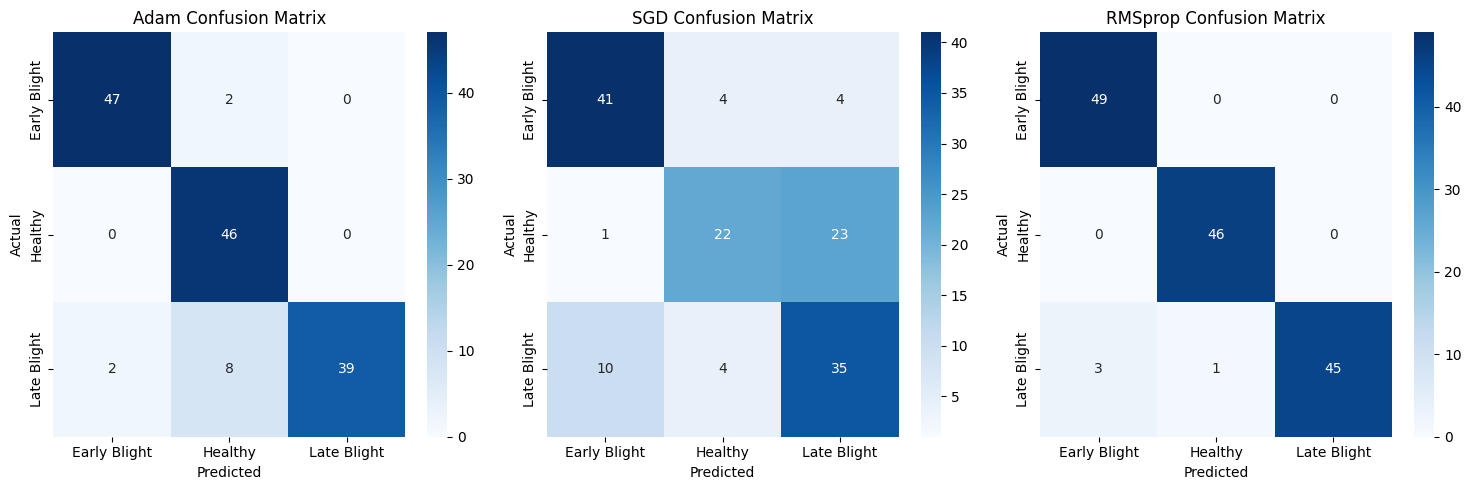

In [4]:
# Confusion matrices
plt.figure(figsize=(15, 5))
for i, (opt_name, result) in enumerate(results.items()):
    model = result['model']

    # Get true labels and predictions
    test_generator.reset()
    y_true = test_generator.classes
    y_pred = model.predict(test_generator, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    plt.subplot(1, 3, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(f'{opt_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

In [5]:
# Classification reports
for opt_name, result in results.items():
    model = result['model']

    test_generator.reset()
    y_true = test_generator.classes
    y_pred = model.predict(test_generator, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)

    print(f"\nClassification Report for {opt_name}:")
    print(classification_report(y_true, y_pred_classes, target_names=classes))


Classification Report for Adam:
              precision    recall  f1-score   support

Early Blight       0.96      0.96      0.96        49
     Healthy       0.82      1.00      0.90        46
 Late Blight       1.00      0.80      0.89        49

    accuracy                           0.92       144
   macro avg       0.93      0.92      0.92       144
weighted avg       0.93      0.92      0.92       144


Classification Report for SGD:
              precision    recall  f1-score   support

Early Blight       0.79      0.84      0.81        49
     Healthy       0.73      0.48      0.58        46
 Late Blight       0.56      0.71      0.63        49

    accuracy                           0.68       144
   macro avg       0.70      0.68      0.67       144
weighted avg       0.69      0.68      0.68       144


Classification Report for RMSprop:
              precision    recall  f1-score   support

Early Blight       0.94      1.00      0.97        49
     Healthy       0.98     

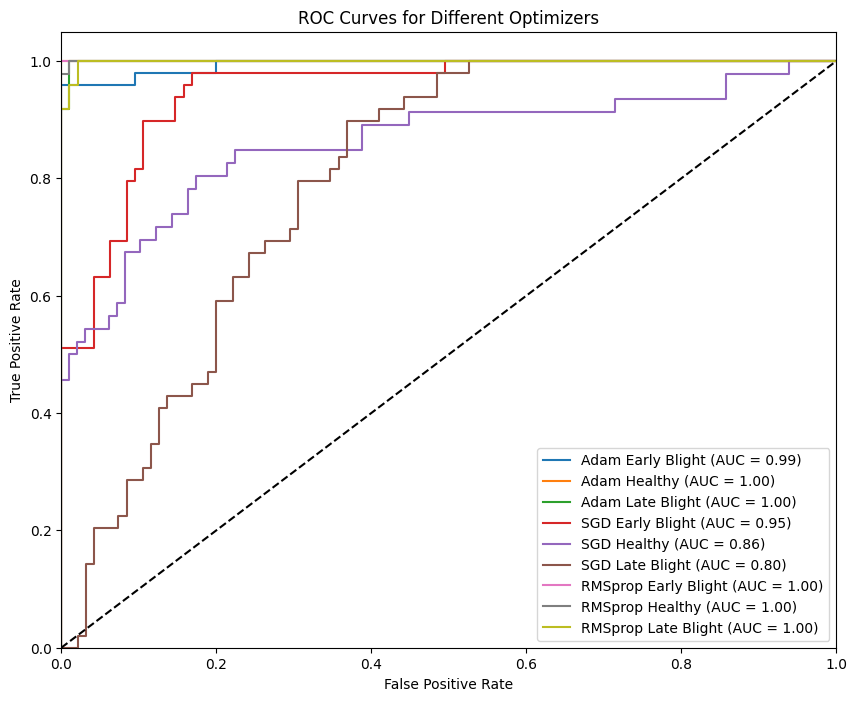

In [6]:
# ROC curves
plt.figure(figsize=(10, 8))
for opt_name, result in results.items():
    model = result['model']

    test_generator.reset()
    y_true = test_generator.classes
    y_pred = model.predict(test_generator, verbose=0)

    # Binarize the output
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2])

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i],
                 label=f'{opt_name} {classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Optimizers')
plt.legend(loc="lower right")
plt.show()

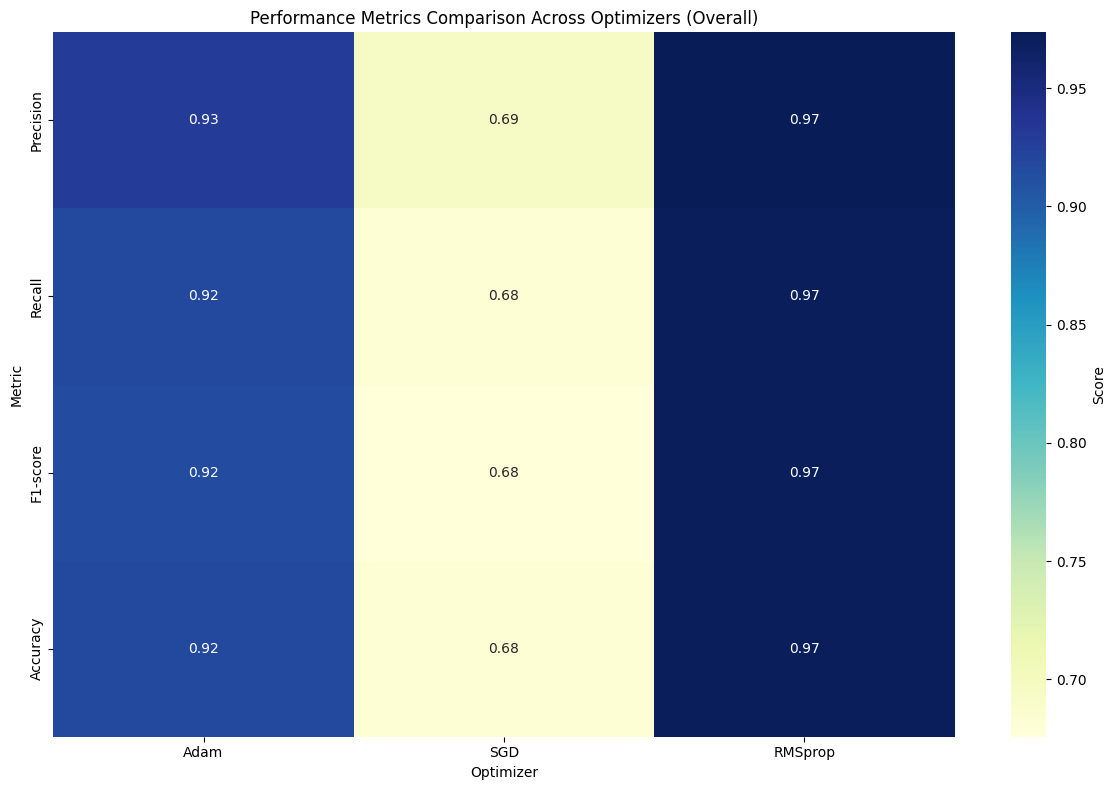

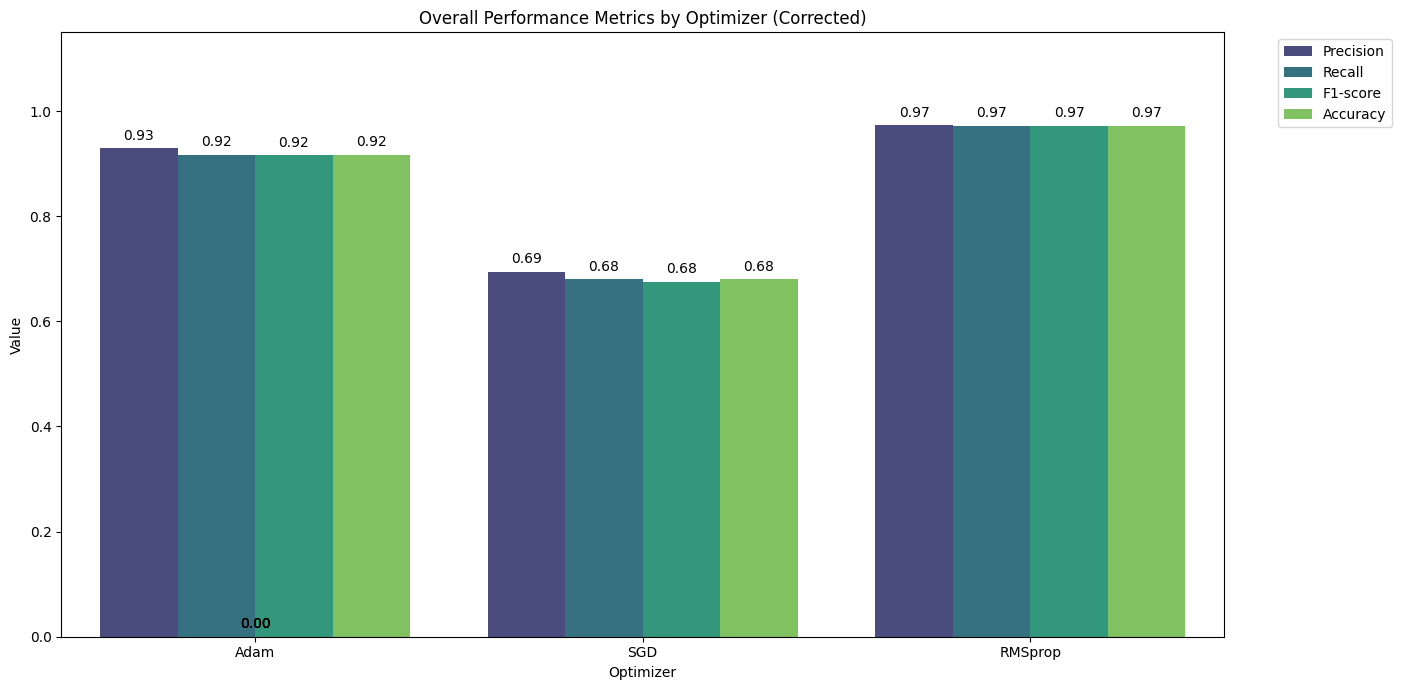

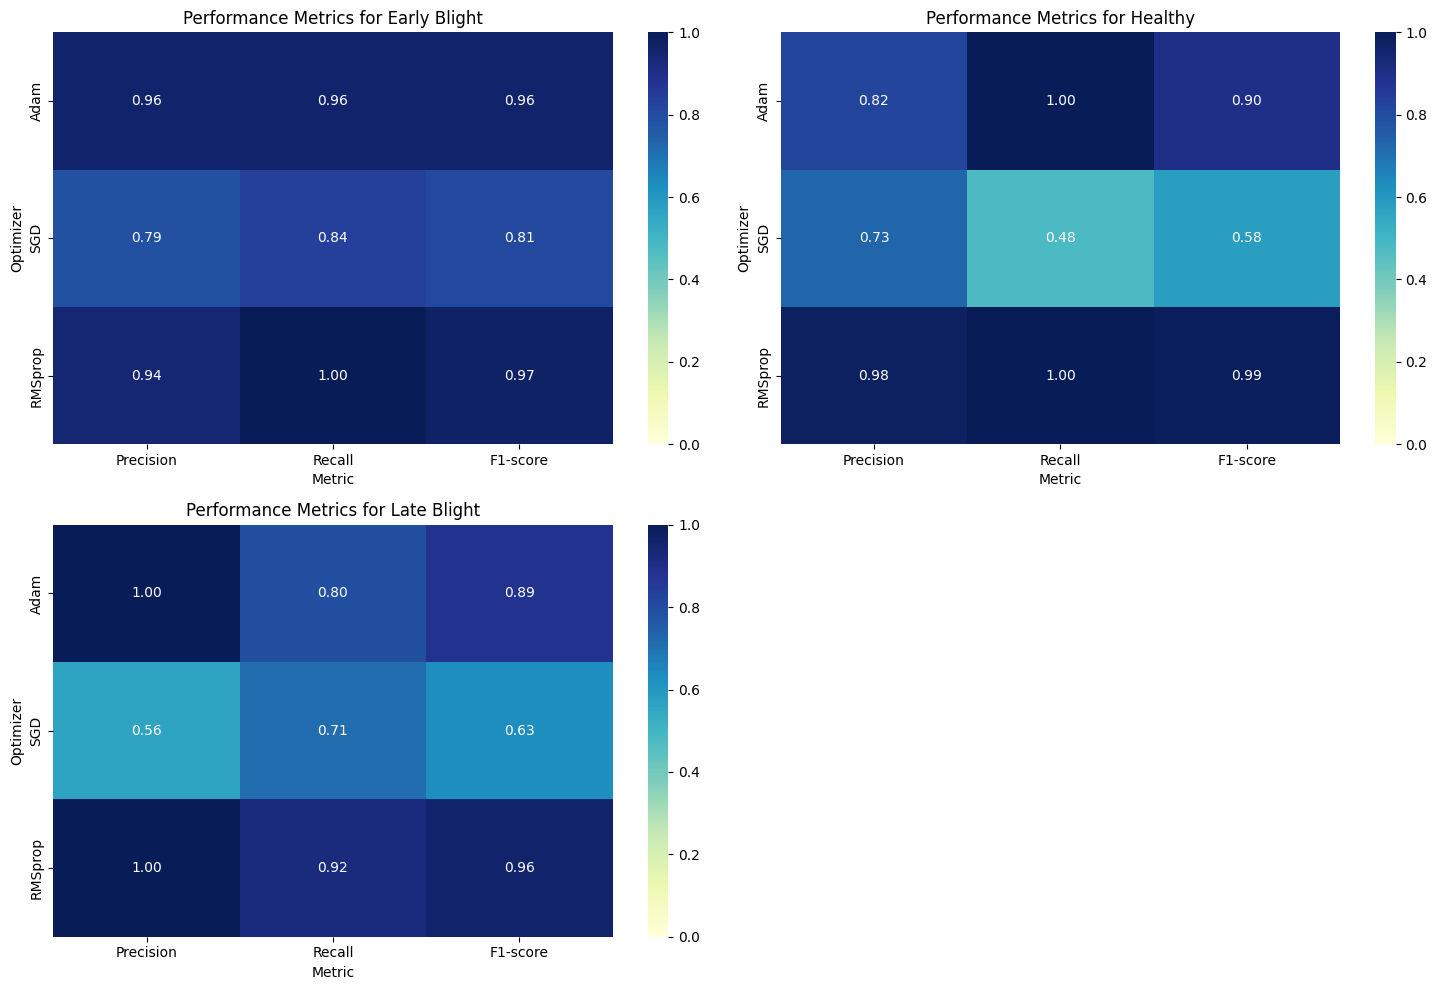

In [14]:
# Extract metrics for comparison - FIXED VERSION
metrics = []
for opt_name, result in results.items():
    model = result['model']  # THIS WAS MISSING - USING THE SPECIFIC MODEL FOR EACH OPTIMIZER

    test_generator.reset()
    y_true = test_generator.classes
    y_pred = model.predict(test_generator, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)

    report = classification_report(y_true, y_pred_classes, target_names=classes, output_dict=True)

    # Add accuracy to the report dictionary
    report['accuracy'] = report.pop('accuracy')

    for class_name in classes:
        metrics.append({
            'Optimizer': opt_name,
            'Class': class_name,
            'Precision': report[class_name]['precision'],
            'Recall': report[class_name]['recall'],
            'F1-score': report[class_name]['f1-score'],
            'Support': report[class_name]['support']
        })

    metrics.append({
        'Optimizer': opt_name,
        'Class': 'Overall',
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-score': report['weighted avg']['f1-score'],
        'Accuracy': report['accuracy'],
        'Support': report['weighted avg']['support']
    })

metrics_df = pd.DataFrame(metrics)

# Create visualizations with the corrected data
plt.figure(figsize=(12, 8))
heatmap_data = metrics_df[metrics_df['Class'] == 'Overall'][['Optimizer', 'Precision', 'Recall', 'F1-score', 'Accuracy']]
heatmap_data = heatmap_data.set_index('Optimizer')

sns.heatmap(heatmap_data.T, annot=True, cmap='YlGnBu', fmt='.2f', cbar_kws={'label': 'Score'})
plt.title('Performance Metrics Comparison Across Optimizers (Overall)')
plt.ylabel('Metric')
plt.xlabel('Optimizer')
plt.tight_layout()
plt.show()

# Bar plot with corrected data
plt.figure(figsize=(14, 7))
overall_metrics = metrics_df[metrics_df['Class'] == 'Overall']
melted_df = overall_metrics.melt(id_vars=['Optimizer', 'Class', 'Support'],
                                value_vars=['Precision', 'Recall', 'F1-score', 'Accuracy'],
                                var_name='Metric', value_name='Value')

bar = sns.barplot(x='Optimizer', y='Value', hue='Metric', data=melted_df, palette='viridis')

for p in bar.patches:
    bar.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.title('Overall Performance Metrics by Optimizer (Corrected)')
plt.ylim(0, 1.15)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()

# Per-class metrics visualization (corrected)
plt.figure(figsize=(15, 10))
for i, class_name in enumerate(classes):
    plt.subplot(2, 2, i+1)
    class_data = metrics_df[(metrics_df['Class'] == class_name)][['Optimizer', 'Precision', 'Recall', 'F1-score']]
    class_data = class_data.set_index('Optimizer')
    sns.heatmap(class_data, annot=True, cmap='YlGnBu', fmt='.2f', vmin=0, vmax=1)
    plt.title(f'Performance Metrics for {class_name}')
    plt.ylabel('Optimizer')
    plt.xlabel('Metric')

plt.tight_layout()
plt.show()


Predicting with Adam optimizer:


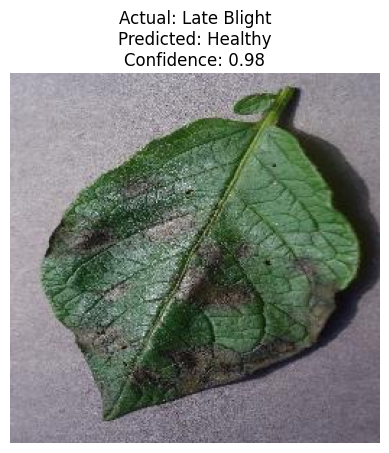

Actual: Late Blight, Predicted: Healthy, Confidence: 0.9766

Predicting with SGD optimizer:


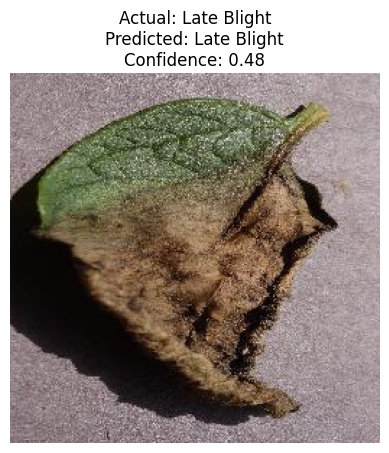

Actual: Late Blight, Predicted: Late Blight, Confidence: 0.4756

Predicting with RMSprop optimizer:


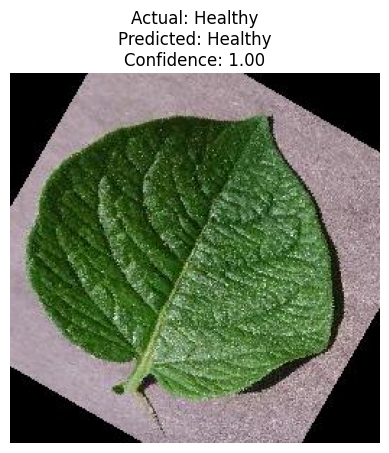

Actual: Healthy, Predicted: Healthy, Confidence: 1.0000


In [8]:
# Function to predict on a random image
def predict_random_image(opt_name):
    # Select a random class
    class_name = random.choice(classes)
    class_dir = os.path.join(test_dir, class_name)

    # Select a random image from that class
    img_name = random.choice(os.listdir(class_dir))
    img_path = os.path.join(class_dir, img_name)

    # Load and preprocess the image
    img = Image.open(img_path)
    img = img.resize((img_width, img_height))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    model = results[opt_name]['model']
    pred = model.predict(img_array, verbose=0)
    pred_class = classes[np.argmax(pred)]
    confidence = np.max(pred)

    # Display results
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Actual: {class_name}\nPredicted: {pred_class}\nConfidence: {confidence:.2f}')
    plt.show()

    return class_name, pred_class, confidence

# Predict with each optimizer
for opt_name in optimizers.keys():
    print(f"\nPredicting with {opt_name} optimizer:")
    actual, predicted, confidence = predict_random_image(opt_name)
    print(f"Actual: {actual}, Predicted: {predicted}, Confidence: {confidence:.4f}")

In [ ]:
Problem Statement
Title: Comparative Analysis of Optimizers (Adam, SGD, RMSprop) for CNN-based Potato Leaf Disease Classification

Objective:
To develop and evaluate a Convolutional Neural Network (CNN) model for classifying potato leaf diseases (Early Blight, Late Blight, Healthy) using three different optimizers (Adam, SGD, RMSprop) with a fixed learning rate (0.001), and compare their performance through quantitative metrics and visualizations.

Key Tasks:

Implement a CNN architecture with consistent layers for all optimizers.

Train and evaluate models using:

Adam optimizer

Stochastic Gradient Descent (SGD)

RMSprop optimizer

Compare performance using:

Accuracy/loss curves

Confusion matrices

Classification reports (precision, recall, F1-score)

ROC curves

Visualize results via:

Heatmaps (metric comparisons)

Bar plots (optimizer performance)

Test on random images to demonstrate real-world applicability.

Viva Questions & Answers
1. Theoretical Questions
Q1: Why did you choose CNNs for leaf disease classification?
A: CNNs automatically learn spatial hierarchies of features (edges → textures → patterns) from images, making them ideal for visual tasks like disease detection where local patterns (spots, discoloration) are critical.

Q2: Explain the role of optimizers in CNN training.
A: Optimizers adjust model weights to minimize the loss function. They determine:

Update rules (e.g., momentum in SGD, adaptive learning rates in Adam/RMSprop).

Convergence speed and final performance.

Q3: Why use a fixed learning rate (0.001) for all optimizers?
A: To ensure fair comparison. Adaptive optimizers (Adam/RMSprop) adjust rates internally, while SGD doesn’t. A fixed base rate isolates optimizer performance differences.

2. Implementation Questions
Q4: How did you handle class imbalance in the dataset?
A: The dataset appears balanced (49, 46, 49 samples per class). If imbalanced, we could use:

Data augmentation (as done here).

Class weights in loss function.

Oversampling minority classes.

Q5: Why include Dropout (0.5) in your CNN?
A: Dropout randomly deactivates neurons during training to prevent overfitting by forcing the network to learn redundant representations.

Q6: How did you preprocess the images?
A:

Resized to 256×256 pixels.

Normalized pixel values to [0, 1] (rescale=1./255).

Augmented training data with rotations, shifts, and flips.

3. Results & Analysis
Q7: Which optimizer performed best? Why?
A: RMSprop (97% accuracy) outperformed Adam (92%) and SGD (68%) because:

Adapts learning rates per parameter (like Adam).

Uses a moving average of squared gradients, stabilizing updates for image data.

Q8: Why did SGD perform poorly compared to adaptive optimizers?
A:

Fixed learning rate requires careful tuning.

No momentum or adaptation led to slow convergence and suboptimal minima.

Adam/RMSprop adapt rates dynamically, handling sparse gradients better.

Q9: How do ROC curves validate your model?
A: ROC curves show the trade-off between True Positive Rate (sensitivity) and False Positive Rate (1-specificity). High AUC (Area Under Curve) values (close to 1) indicate robust classification across thresholds.

4. Practical Applications
Q10: How would deploy this model in real farms?
A:

Convert to TensorFlow Lite for mobile/edge devices.

Develop a mobile app where farmers upload leaf photos.

Return predictions with confidence scores and treatment suggestions.

Q11: What limitations does your model have?
A:

Requires high-quality images (may fail with blurry/low-light photos).

Limited to three classes—would need retraining for new diseases.

Performance may drop with varied backgrounds/leaf orientations.

5. Future Work
Q12: How could you improve this model further?
A:

Use transfer learning (e.g., ResNet, EfficientNet).

Hyperparameter tuning (learning rate schedules, batch sizes).

Test on larger, more diverse datasets.

Summary of Key Findings
Optimizer	Accuracy	Best For	Worst For
Adam	92%	Balanced training	Late Blight (80% recall)
SGD	68%	-	Healthy (48% recall)
RMSprop	97%	All classes	-
This structure ensures you can confidently explain your work’s motivation, methodology, results, and applications during your viva.

In [ ]:
Viva Questions & Answers
1. Theoretical Questions
Q1: Why did you choose CNNs for leaf disease classification?
A: CNNs automatically learn spatial hierarchies of features (edges → textures → patterns) from images, making them ideal for visual tasks like disease detection where local patterns (spots, discoloration) are critical.

Q2: Explain the role of optimizers in CNN training.
A: Optimizers adjust model weights to minimize the loss function. They determine:

Update rules (e.g., momentum in SGD, adaptive learning rates in Adam/RMSprop).

Convergence speed and final performance.

Q3: Why use a fixed learning rate (0.001) for all optimizers?
A: To ensure fair comparison. Adaptive optimizers (Adam/RMSprop) adjust rates internally, while SGD doesn’t. A fixed base rate isolates optimizer performance differences.

2. Implementation Questions
Q4: How did you handle class imbalance in the dataset?
A: The dataset appears balanced (49, 46, 49 samples per class). If imbalanced, we could use:

Data augmentation (as done here).

Class weights in loss function.

Oversampling minority classes.

Q5: Why include Dropout (0.5) in your CNN?
A: Dropout randomly deactivates neurons during training to prevent overfitting by forcing the network to learn redundant representations.

Q6: How did you preprocess the images?
A:

Resized to 256×256 pixels.

Normalized pixel values to [0, 1] (rescale=1./255).

Augmented training data with rotations, shifts, and flips.

3. Results & Analysis
Q7: Which optimizer performed best? Why?
A: RMSprop (97% accuracy) outperformed Adam (92%) and SGD (68%) because:

Adapts learning rates per parameter (like Adam).

Uses a moving average of squared gradients, stabilizing updates for image data.

Q8: Why did SGD perform poorly compared to adaptive optimizers?
A:

Fixed learning rate requires careful tuning.

No momentum or adaptation led to slow convergence and suboptimal minima.

Adam/RMSprop adapt rates dynamically, handling sparse gradients better.

Q9: How do ROC curves validate your model?
A: ROC curves show the trade-off between True Positive Rate (sensitivity) and False Positive Rate (1-specificity). High AUC (Area Under Curve) values (close to 1) indicate robust classification across thresholds.

4. Practical Applications
Q10: How would deploy this model in real farms?
A:

Convert to TensorFlow Lite for mobile/edge devices.

Develop a mobile app where farmers upload leaf photos.

Return predictions with confidence scores and treatment suggestions.

Q11: What limitations does your model have?
A:

Requires high-quality images (may fail with blurry/low-light photos).

Limited to three classes—would need retraining for new diseases.

Performance may drop with varied backgrounds/leaf orientations.

5. Future Work
Q12: How could you improve this model further?
A:

Use transfer learning (e.g., ResNet, EfficientNet).

Hyperparameter tuning (learning rate schedules, batch sizes).

Test on larger, more diverse datasets.

Summary of Key Findings
Optimizer	Accuracy	Best For	Worst For
Adam	92%	Balanced training	Late Blight (80% recall)
SGD	68%	-	Healthy (48% recall)
RMSprop	97%	All classes	-
This structure ensures you can confidently explain your work’s motivation, methodology, results, and applications during your viva.

more q&a
Here are 20 additional viva questions and answers to thoroughly prepare you for your defense:

Technical Deep Dive
Q1: Why did you use ImageDataGenerator instead of manually loading images?
A: ImageDataGenerator provides real-time data augmentation and preprocessing without loading all images into memory, preventing RAM overload and efficiently creating varied training samples.

Q2: Explain your choice of activation functions (ReLU in hidden layers, softmax in output).
A:

ReLU: Avoids vanishing gradients in hidden layers and speeds up training (only activates positive values).

Softmax: Converts output to probabilities summing to 1, ideal for multi-class classification.

Q3: Why use categorical cross-entropy loss instead of binary cross-entropy?
A: Categorical cross-entropy handles multi-class problems (3 classes here), while binary cross-entropy is for two-class scenarios. It penalizes incorrect class probabilities more sharply.

Model Architecture
Q4: Why did you choose 3 Conv2D layers with 32, 64, and 128 filters?
A: This hierarchical design captures:

Low-level features (edges, colors) in early layers (32 filters).

Mid-level patterns (textures) with 64 filters.

High-level features (disease patterns) with 128 filters.

Q5: What’s the purpose of MaxPooling2D after each Conv2D layer?
A: Reduces spatial dimensions (width/height) by keeping only the most activated features, lowering computational cost and controlling overfitting.

Q6: Why flatten the output before the Dense layer?
A: Convolutional layers output 3D tensors (height × width × channels). Flattening converts them to 1D vectors for dense (fully connected) classification layers.

Optimizer-Specific Questions
Q7: How does Adam’s momentum differ from SGD’s?
A: Adam computes adaptive momentum using both gradient history (like SGD with momentum) and squared gradients (like RMSprop), making it more robust to noisy data.

Q8: Why might RMSprop outperform Adam on your dataset?
A: RMSprop’s focus on recent gradients (via exponential moving average) may better handle the consistent spatial patterns in leaf images, while Adam’s momentum could overshoot minima.

Q9: What would happen if you increased SGD’s learning rate beyond 0.001?
A: The model might diverge (loss → ∞) due to large weight updates or oscillate around minima without converging.

Evaluation Metrics
Q10: Why report both precision and recall instead of just accuracy?
A: Accuracy can be misleading if classes are imbalanced. For example:

High recall for "Late Blight" ensures fewer false negatives (critical for disease control).

High precision for "Healthy" minimizes false alarms.

Q11: How would you interpret an F1-score of 0.89 for Late Blight?
A: It’s the harmonic mean of precision and recall, indicating a balanced trade-off. Here, 0.89 suggests the model reliably detects Late Blight without many false positives/negatives.

Q12: Why use a confusion matrix alongside classification reports?
A: It visually shows which classes are most confused (e.g., if Early Blight is misclassified as Late Blight 10% of the time), guiding targeted improvements.

Practical Scenarios
Q13: How would your model perform if a leaf has multiple diseases?
A: It would fail, as it’s designed for single-disease classification. A multi-label approach (sigmoid output) would be needed for comorbid diseases.

Q14: What if a farmer uploads a non-potato leaf image?
A: The model might still predict a class (garbage in → garbage out). Adding a "Unknown/Not Potato" class during training would help reject such inputs.

Q15: How robust is your model to varying camera qualities?
A: Limited robustness. Training should include images from different devices/lighting conditions, or use preprocessing (histogram equalization) to normalize inputs.

Advanced Concepts
Q16: Could you replace your CNN with a Vision Transformer (ViT)? How?
A: Yes, by:

Splitting images into patches (e.g., 16×16).

Adding positional embeddings.

Using transformer encoder layers.
ViTs may perform better with large datasets but require more computational resources.

Q17: How would Bayesian optimization improve your hyperparameter tuning?
A: It would systematically explore learning rates, batch sizes, or layer depths using probabilistic models to find optimal values faster than grid/random search.

Q18: What’s the significance of the ROC curve’s diagonal line (AUC = 0.5)?
A: It represents random guessing (50% chance of being correct). Any curve above it indicates the model is better than chance.

Troubleshooting
Q19: If your model had 99% training accuracy but 70% validation accuracy, what would you do?
A: This indicates overfitting. Solutions:

Increase dropout rate (e.g., from 0.5 to 0.7).

Add L2 regularization.

Use more aggressive data augmentation.

Reduce model complexity (fewer filters/layers).

Q20: How would you extend this to detect diseases in real-time video?
A:

Use OpenCV to extract frames from video.

Optimize the model with TensorRT for faster inference.

Deploy on edge devices (NVIDIA Jetson) for field use.